In [36]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms as T

# Step 1: Load ACDC Data with Multi-Class Support
def load_acdc_data(data_path):
    """
    Load images and masks from the ACDC dataset.
    Args:
        data_path (str): Path to the dataset directory (training or testing).
    Returns:
        tuple: Two lists containing paths to images and masks.
    """
    images, masks = [], []

    for patient_folder in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_gt.nii.gz'):  # Mask files
                    masks.append(os.path.join(patient_path, file))
                elif '_frame' in file and not file.endswith('_gt.nii.gz'):  # Image files
                    images.append(os.path.join(patient_path, file))

    images.sort()
    masks.sort()

    if len(images) != len(masks):
        raise ValueError(f"Mismatch in counts: {len(images)} images and {len(masks)} masks.")

    print(f"Loaded {len(images)} images and {len(masks)} masks from {data_path}.")
    return images, masks

# Define Paths
train_data_path = "D:/1/Mohsin/ACDC/database/training"
test_data_path = "D:/1/Mohsin/ACDC/database/testing"

# Load Data
train_images, train_masks = load_acdc_data(train_data_path)
test_images, test_masks = load_acdc_data(test_data_path)


Loaded 200 images and 200 masks from D:/1/Mohsin/ACDC/database/training.
Loaded 100 images and 100 masks from D:/1/Mohsin/ACDC/database/testing.


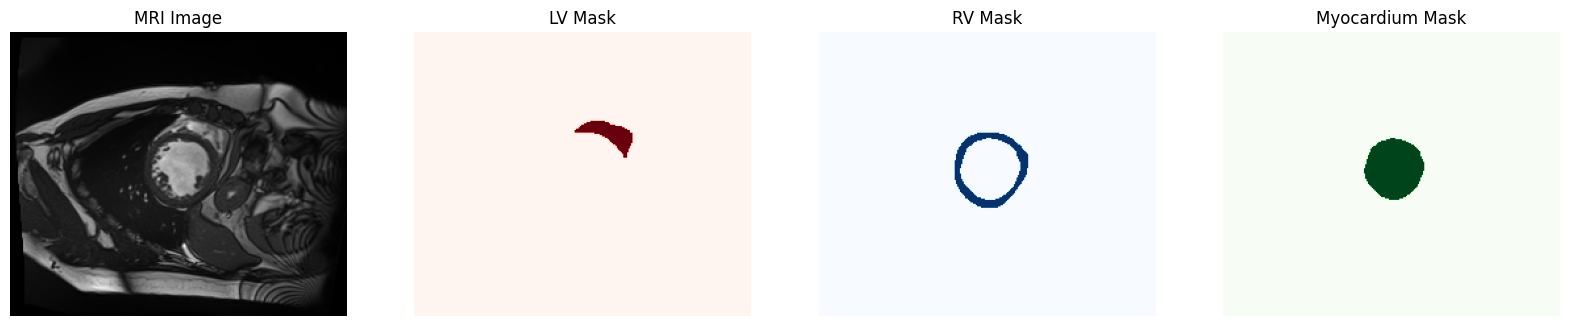

In [37]:
# Step 2: Visualize Ground Truth
def visualize_sample(image_path, mask_path):
    """
    Visualize the middle slice of an image and its multi-class mask (LV, RV, Myocardium).
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    # Extract classes from the mask
    lv_mask = (mask_data[:, :, middle_slice] == 1).astype(float)
    rv_mask = (mask_data[:, :, middle_slice] == 2).astype(float)
    myo_mask = (mask_data[:, :, middle_slice] == 3).astype(float)

    plt.figure(figsize=(20, 5))

    # MRI Image
    plt.subplot(1, 4, 1)
    plt.imshow(image_data[:, :, middle_slice], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    # LV Mask
    plt.subplot(1, 4, 2)
    plt.imshow(lv_mask, cmap="Reds")
    plt.title("LV Mask")
    plt.axis("off")

    # RV Mask
    plt.subplot(1, 4, 3)
    plt.imshow(rv_mask, cmap="Blues")
    plt.title("RV Mask")
    plt.axis("off")

    # Myocardium Mask
    plt.subplot(1, 4, 4)
    plt.imshow(myo_mask, cmap="Greens")
    plt.title("Myocardium Mask")
    plt.axis("off")

    plt.show()

# Visualize a training sample
visualize_sample(train_images[0], train_masks[0])


In [38]:
# Step 3: Data Preprocessing
def preprocess_data(image_path, mask_path, target_size=(128, 128)):
    """
    Preprocess the image and mask by resizing and normalizing.
    Args:
        image_path (str): Path to the MRI image.
        mask_path (str): Path to the segmentation mask.
        target_size (tuple): Target size for resizing (height, width).
    Returns:
        tuple: Preprocessed image and mask.
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    image_slice = image_data[:, :, middle_slice]
    mask_slice = mask_data[:, :, middle_slice]

    # Normalize image
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))

    # Resize image and mask
    image_resized = T.functional.resize(torch.tensor(image_slice).unsqueeze(0), target_size)
    mask_resized = T.functional.resize(torch.tensor(mask_slice).unsqueeze(0), target_size, interpolation=T.InterpolationMode.NEAREST)

    return image_resized.squeeze(0).numpy(), mask_resized.squeeze(0).numpy()

# Preprocess a sample
preprocessed_image, preprocessed_mask = preprocess_data(train_images[0], train_masks[0])


In [39]:
# Step 4: Dataset and DataLoader Classes
class CardiacDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=(128, 128)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image, mask = preprocess_data(image_path, mask_path, self.target_size)

        # Convert to tensors
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask_tensor = torch.tensor(mask, dtype=torch.long)  # Masks as class indices

        return image_tensor, mask_tensor

# Create Dataset and DataLoader
train_dataset = CardiacDataset(train_images, train_masks)
test_dataset = CardiacDataset(test_images, test_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [40]:
# Step 5: Define the UNet Model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        bottleneck = self.bottleneck(self.pool3(enc3))

        dec3 = self.decoder3(torch.cat([self.upconv3(bottleneck), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))

        return self.output(dec1)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=4).to(device)


In [41]:
# Step 6: Define Loss Function and Optimizer
import torch.optim as optim

# Define CrossEntropyLoss for multi-class segmentation
criterion = nn.CrossEntropyLoss()

# Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [42]:
# Step 7: Define Training Function
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)


In [43]:
# Step 8: Define Validation Function
def validate_model(model, test_loader, criterion, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

    return val_loss / len(test_loader)


In [ ]:
# Step 9: Training Loop
num_epochs = 10  # Set the number of epochs
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    val_loss = validate_model(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
# Step 10: Evaluate Model on Test Data
from sklearn.metrics import jaccard_score

def evaluate_iou(model, test_loader, device, num_classes=4):
    """
    Evaluate the model to calculate IOU for each class (LV, RV, Myocardium).
    """
    model.eval()
    iou_scores = {c: [] for c in range(num_classes)}  # Store IOU per class

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Get predictions
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            # Flatten for metrics
            predictions_flat = predictions.cpu().numpy().flatten()
            masks_flat = masks.cpu().numpy().flatten()

            # Calculate IOU for each class
            for c in range(num_classes):
                iou = jaccard_score(
                    (masks_flat == c).astype(int),
                    (predictions_flat == c).astype(int),
                    average="binary",
                )
                iou_scores[c].append(iou)

    # Average IOU across all slices for each class
    avg_iou_scores = {c: np.mean(iou_scores[c]) for c in range(num_classes)}
    return avg_iou_scores

# Calculate IOU for LV, RV, and Myocardium
iou_results = evaluate_iou(model, test_loader, device)
print("IOU Results:")
print(f"Background: {iou_results[0]:.4f}")
print(f"Left Ventricle (LV): {iou_results[1]:.4f}")
print(f"Right Ventricle (RV): {iou_results[2]:.4f}")
print(f"Myocardium: {iou_results[3]:.4f}")




# Step 11: Plot IOU for LV, RV, and Myocardium
def plot_iou(iou_results):
    """
    Plot IOU scores for each class.
    """
    classes = ["Background", "LV", "RV", "Myocardium"]
    scores = [iou_results[0], iou_results[1], iou_results[2], iou_results[3]]

    plt.figure(figsize=(8, 6))
    plt.bar(classes, scores, color=["gray", "red", "blue", "green"])
    plt.ylim(0, 1)
    plt.xlabel("Classes")
    plt.ylabel("IOU Score")
    plt.title("IOU Scores for LV, RV, and Myocardium")
    plt.show()

# Plot IOU
plot_iou(iou_results)


In [ ]:
# Step 11: Visualize Predictions
def visualize_predictions(model, test_loader, device, num_samples=3):
    model.eval()
    samples = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Get predictions
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if samples >= num_samples:
                    return

                # Extract data for visualization
                image = images[i].cpu().squeeze(0).numpy()
                mask = masks[i].cpu().numpy()
                pred = predictions[i].cpu().numpy()

                plt.figure(figsize=(15, 5))

                # Original Image
                plt.subplot(1, 3, 1)
                plt.imshow(image, cmap="gray")
                plt.title("MRI Image")
                plt.axis("off")

                # Ground Truth
                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap="viridis")
                plt.title("Ground Truth Mask")
                plt.axis("off")

                # Prediction
                plt.subplot(1, 3, 3)
                plt.imshow(pred, cmap="viridis")
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.show()

                samples += 1

# Visualize a few predictions
visualize_predictions(model, test_loader, device, num_samples=3)


In [ ]:
# Step 12: Calculate Class-Wise Areas Across Slices
def calculate_class_areas(model, test_loader, device, num_classes=4):
    """
    Calculate areas (pixel counts) for LV, RV, and Myocardium for ground truth and predictions.
    """
    model.eval()
    areas_gt = {c: [] for c in range(num_classes)}  # Ground truth areas
    areas_pred = {c: [] for c in range(num_classes)}  # Predicted areas

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Get predictions
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            # Calculate areas for each slice
            for c in range(num_classes):
                areas_gt[c].append((masks == c).sum().item())
                areas_pred[c].append((predictions == c).sum().item())

    # Average areas across slices
    avg_areas_gt = {c: np.mean(areas_gt[c]) for c in range(num_classes)}
    avg_areas_pred = {c: np.mean(areas_pred[c]) for c in range(num_classes)}
    return areas_gt, areas_pred, avg_areas_gt, avg_areas_pred

# Calculate class-wise areas
areas_gt, areas_pred, avg_areas_gt, avg_areas_pred = calculate_class_areas(model, test_loader, device)

# Print Average Areas
print("Average Areas (Pixels):")
for c, label in enumerate(["Background", "LV", "RV", "Myocardium"]):
    print(f"{label} (Ground Truth): {avg_areas_gt[c]:.2f}")
    print(f"{label} (Prediction): {avg_areas_pred[c]:.2f}")


In [ ]:
# Step 13: Plot Class-Wise Area Curves
def plot_class_areas(areas_gt, areas_pred):
    """
    Plot area curves for LV, RV, and Myocardium (ground truth and predictions).
    """
    classes = ["Background", "LV", "RV", "Myocardium"]
    colors = ["gray", "red", "blue", "green"]

    plt.figure(figsize=(12, 8))
    
    for c in range(1, len(classes)):  # Skip background
        plt.plot(areas_gt[c], label=f"{classes[c]} (Ground Truth)", linestyle="--", color=colors[c])
        plt.plot(areas_pred[c], label=f"{classes[c]} (Prediction)", linestyle="-", color=colors[c])

    plt.xlabel("Slice Index")
    plt.ylabel("Area (Pixels)")
    plt.title("Class-Wise Area Distribution Across Slices")
    plt.legend()
    plt.grid()
    plt.show()

# Plot area curves
plot_class_areas(areas_gt, areas_pred)
